## Business Problem 
#### The objective behind this project is to analyse and come up with best possible neighborhood options in the Phuket to rent a apartment. Use data science and machine learning techniques with python to find neighborhood which has more features which will make living more comfortable and pocket friendly.

In [1]:
#load Librabries
import pandas as pd
import numpy as np
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
from geopy.distance import great_circle
import geocoder
# map rendering library
import folium
# library to handle JSON files
import json 
from pandas.io.json import json_normalize 
# library to handle requests
import requests 
from requests import get
from bs4 import BeautifulSoup
import re
from time import sleep
# Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
Apartment_list_available= True
Webpage_number = 1
Apartments=[]

while Apartment_list_available:
    headers = {'User-agent': 'Googlebot'}
    url='https://www.thailand-property.com/properties-for-rent/phuket?page={}'.format(Webpage_number)
    response=requests.get(url,headers=headers).text
    soup= BeautifulSoup(response ,'html.parser')
    apartment_containers = soup.find_all('div', class_="search-list normal")
    apartment_containers_featured = soup.find_all('div', class_="search-list featured")
    apartment_containers = apartment_containers + apartment_containers_featured
    if len(apartment_containers) == 0:
        break
    
    for apt in apartment_containers:
        try:
            size_elements = apt.find('div', class_="accommodation").find_all("li")
            size=size_elements[-1].text.split()[0]
            if(int(size) < 10):
                size = np.nan
        except:
            size = np.nan

        try:
            rooms = apt.find('div', class_="accommodation").find_all("li")[0].text
            if "m2" in rooms:
                rooms=np.nan
        except:
            rooms = np.nan

        try:
            price = apt.find('div', class_="price").text.split()[1].replace(',','')
        except:
            price = np.nan
                
        try:
            address = apt.find('div', class_="location").text.split(',')[0]
            address=address[2:]
        except:
            address = None 
        print(str(address)+" "+ str(size)+" "+str(price)+" "+str(rooms))
        Apartments.append([ address, size, rooms, price])
    Webpage_number += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

Thalang 40 21000  1
Mueang Phuket nan 6000  1
Thalang 285 53000  3
Thalang 485 85000  5
Mueang Phuket 36 8500  1
Thalang 100 17500  1
Thalang nan 38000  1
Mueang Phuket 220 50000  3
Kathu nan 40000  3
Thalang 396 40000  4
Kathu 103 25000  2
Kathu nan 100000  4
Thalang nan 32000  3
Mueang Phuket nan 35000  2
Thalang nan 35000  3
Thalang nan 50000 nan
Phuket
 nan 45000  3
Mueang Phuket nan 20000  2
Thalang nan 23000  2
Thalang nan 40000  2
Mueang Phuket nan 35000  2
Mueang Phuket nan 80000  3
Mueang Phuket nan 75000  4
Mueang Phuket nan 78000  3
Thalang nan 120000  4
Thalang 106 20000  2
Kathu nan 40000  3
Thalang 435 69000  4
Kathu 180 20000  3
Thalang 180 25000  2
Thalang 388 150000  4
Mueang Phuket 600 120000  4
Mueang Phuket nan 32000  3
Mueang Phuket 260 110000  3
Thalang 265 145000  4
Thalang 65 27000  2
Kathu 150 79000  5
Mueang Phuket 800 48000  3
Mueang Phuket 450 150000  4
Mueang Phuket 160 72000  3
Mueang Phuket 170 38000  2
Thalang 300 45000  2
Kathu 200 35000  3
Mueang Phuke

In [3]:
#set column names and build a dataframe from previous results
column_names = ['Address', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(Apartments, columns=column_names)
rental_properties.drop(rental_properties.loc[rental_properties['Price']=="for"].index ,inplace=True)

In [4]:
#Pre-process & Visualize the data
rental_properties['Size'] = rental_properties['Size'].astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')
rental_properties['Price'] = rental_properties['Price'].astype('float')
rental_properties['Address'] = rental_properties['Address'].astype('str')
address=[]
for _property in rental_properties['Address']:
    address.append(str(_property).replace("\n","").replace("BTS","").replace("  "," "))
rental_properties['City'] = address

In [5]:
#Calculate the price per meter squared
rental_properties['Price/m2'] = (rental_properties['Price']/rental_properties['Size']).round(2)
rental_properties.head()

,Address,Size,Rooms,Price,City,Price/m2
0,Thalang,40.0,1.0,21000.0,Thalang,525.00
1,Mueang Phuket,NaN,1.0,6000.0,Mueang Phuket,NaN
2,Thalang,285.0,3.0,53000.0,Thalang,185.96
3,Thalang,485.0,5.0,85000.0,Thalang,175.26
4,Mueang Phuket,36.0,1.0,8500.0,Mueang Phuket,236.11


In [6]:

rental_properties.describe()

,Size,Rooms,Price,Price/m2
count,968.000000,1223.000000,1.249000e+03,968.000000
mean,275.933884,3.273917,8.419704e+04,345.826622
std,200.591075,3.947822,1.040214e+05,688.243732
min,23.000000,1.000000,5.000000e+03,43.100000
25%,142.250000,2.000000,3.300000e+04,183.330000
50%,226.500000,3.000000,5.900000e+04,256.830000
75%,350.500000,4.000000,9.500000e+04,376.700000
max,982.000000,85.000000,1.500000e+06,17647.060000


In [7]:
rental_properties.dtypes

Address      object
Size        float64
Rooms       float64
Price       float64
City         object
Price/m2    float64
dtype: object

In [8]:
#Remove rows with NA values in all columns except for the number of rooms since there are too many missing values
rental_properties.dropna(subset=['Address', 'Rooms', 'Size', 'Price'], inplace=True)

In [9]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 952 apartments in the dataset


In [10]:
#Let's check how many apartments per room number we have in our dataset
rental_properties['Rooms'].value_counts()

3.0     357
2.0     204
4.0     182
1.0     116
5.0      74
6.0       8
7.0       2
8.0       1
15.0      1
85.0      1
56.0      1
11.0      1
60.0      1
24.0      1
47.0      1
25.0      1
Name: Rooms, dtype: int64

In [11]:
#Let's remove all rows with rooms larger than 6. Apartments bigger than 6 will most likely be luxurious apartments and does not fit the target group.
rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

[Text(0, 0, 'Thalang'),
 Text(0, 0, 'Mueang Phuket'),
 Text(0, 0, 'Kathu'),
 Text(0, 0, 'Central West Beaches Phuket'),
 Text(0, 0, 'Phuket'),
 Text(0, 0, 'Phuket Wongwian Yai')]

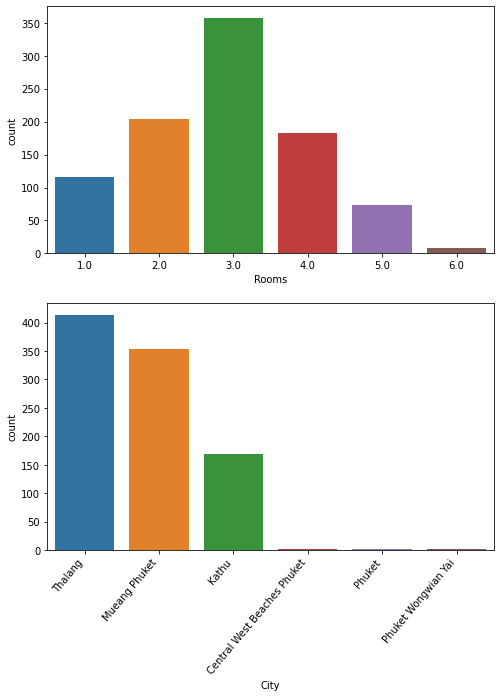

In [12]:
#We can visualize the number of apartments per room number and number of apartments in each city
fig, ax =plt.subplots(2,1, figsize=(8,10))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['City'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

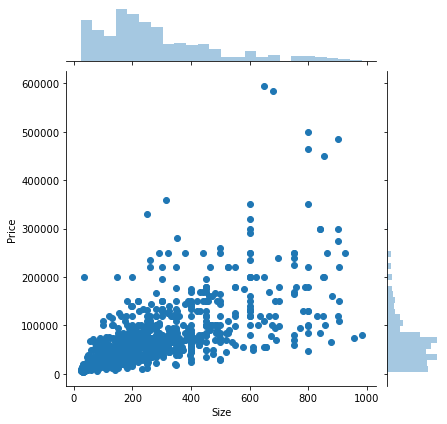

In [13]:
#Plot the price and check for any outliers
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

In [14]:
#Remove the outliers
rental_properties = rental_properties[rental_properties['Price'] <= 200000]

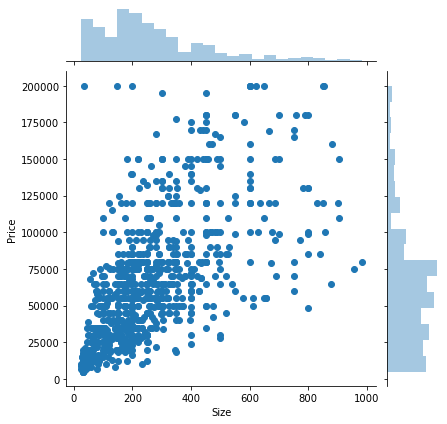

In [15]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

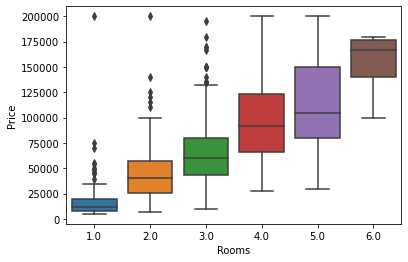

In [16]:
#We expect the value of properties to go up as the number of rooms increases. 
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

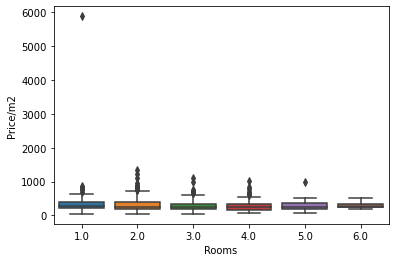

In [17]:
#In the following plot we can see that the price/m2 is in the same price range for all size apartments besides for single room apartments where the price/m2 goes even higher
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

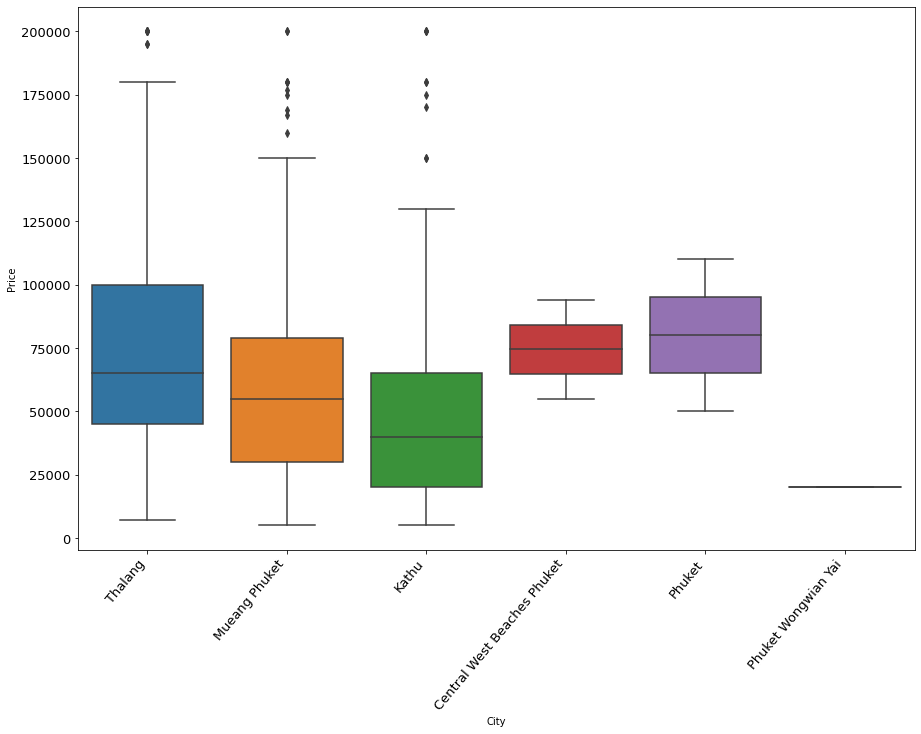

In [18]:
#Let's also check the differences in price per m2 in each district
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='City', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

In [19]:
#get list of neighborhoods
_neighborhoods = rental_properties['City'].drop_duplicates()
_neighborhoods.count()
Phuket_neighborhoods=[]
for e in _neighborhoods:
    Phuket_neighborhoods.append(str(e))

In [20]:
#Get coordinates for each neighborhoods
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Phuket'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
coords = [ get_latlng(neighborhood) for neighborhood in Phuket_neighborhoods]
neighborhood_coordinates = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
neighborhood_coordinates['Neighborhood'] = Phuket_neighborhoods
neighborhood_coordinates

,Latitude,Longitude,Neighborhood
0,8.031753,98.333984,Thalang
1,7.889464,98.385307,Mueang Phuket
2,7.908981,98.333378,Kathu
3,7.890197,98.398584,Central West Beaches Phuket
4,7.890197,98.398584,Phuket
5,7.881933,98.391113,Phuket Wongwian Yai


In [21]:
Address_phuket = 'Phuket'
geolocator = Nominatim(user_agent="my-phuket")
location = geolocator.geocode(Address_phuket)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Phuket {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Phuket 7.9366015, 98.3529292.


In [22]:
# can visualize the citier on a map
map_Phuket = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_coordinates['Latitude'], neighborhood_coordinates['Longitude'], neighborhood_coordinates['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Phuket)  
    
map_Phuket

In [23]:
#Calculate the mean per district
mean_per_location = rental_properties.groupby('City').mean().reset_index()
mean_per_location.head()

,City,Size,Rooms,Price,Price/m2
0,Central West Beaches Phuket,259.500000,3.000000,74500.000000,297.005000
1,Kathu,209.650307,2.552147,50575.460123,274.786687
2,Mueang Phuket,240.872464,2.794203,58095.072464,307.579536
3,Phuket,562.000000,4.000000,80000.000000,137.360000
4,Phuket Wongwian Yai,62.000000,2.000000,20000.000000,322.580000


In [24]:
#Define Foursquare Credentials and Version
CLIENT_ID = '3IM1TMFICMRC2TVBAZCTYVYAD43RVOEXM45KCQT42VPHVEMY' 
CLIENT_SECRET = 'OVS1VZLR2I1HXYL0D5AOC002P4WTAQWEDMIXHL55GWTVKQJH' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500

venues = []

for lat, long, neighborhood in zip(neighborhood_coordinates['Latitude'], neighborhood_coordinates['Longitude'], neighborhood_coordinates['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((  
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))
Phuket_venues_df = pd.DataFrame(venues)
Phuket_venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(Phuket_venues_df.shape)
Phuket_venues_df.head()

Your credentails:
CLIENT_ID: 3IM1TMFICMRC2TVBAZCTYVYAD43RVOEXM45KCQT42VPHVEMY
CLIENT_SECRET:OVS1VZLR2I1HXYL0D5AOC002P4WTAQWEDMIXHL55GWTVKQJH
(123, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Thalang,8.031753,98.333984,7-11 ถลาง,8.028449,98.333223,Food & Drink Shop
1,Thalang,8.031753,98.333984,ร้านบ้านคุณปู่,8.031101,98.333296,Thai Restaurant
2,Thalang,8.031753,98.333984,Koom Ngern Restaurant (ร้านอาหารคุ้มเงิน),8.033560,98.333313,Restaurant
3,Thalang,8.031753,98.333984,แยกถลาง (Thalang Intersection),8.027498,98.332569,Intersection
4,Mueang Phuket,7.889464,98.385307,Brown Café,7.889526,98.386904,Coffee Shop


In [25]:
print('{} venues are collected'.format(Phuket_venues_df.shape[0]))

123 venues are collected


In [26]:

Phuket_venues_df.groupby('Neighborhood').count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Central West Beaches Phuket,4,4,4,4,4,4
Kathu,18,18,18,18,18,18
Mueang Phuket,41,41,41,41,41,41
Phuket,4,4,4,4,4,4
Phuket Wongwian Yai,52,52,52,52,52,52
Thalang,4,4,4,4,4,4


In [27]:
print('There are {} uniques categories.'.format(len(Phuket_venues_df['VenueCategory'].unique())))

There are 53 uniques categories.


In [28]:
#Analyze Each Neighborhood
Phuket_onehot = pd.get_dummies(Phuket_venues_df[['VenueCategory']], prefix="", prefix_sep="")
Phuket_onehot['Neighborhoods'] = Phuket_venues_df['Neighborhood'] 
fixed_columns = [Phuket_onehot.columns[-1]] + list(Phuket_onehot.columns[:-1])
Phuket_onehot = Phuket_onehot[fixed_columns]
print(Phuket_onehot.shape)
Phuket_onehot.head()

(123, 54)


,Neighborhoods,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,...,Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Souvenir Shop,Spa,Steakhouse,Tea Room,Thai Restaurant,Zoo
0,Thalang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Thalang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Thalang,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Thalang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mueang Phuket,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#let's group rows by Neighborhoods and by taking the mean of the frequency of occurrence of each category
Phuket_grouped = Phuket_onehot.groupby('Neighborhoods').mean().reset_index()
Phuket_grouped

,Neighborhoods,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,...,Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Souvenir Shop,Spa,Steakhouse,Tea Room,Thai Restaurant,Zoo
0,Central West Beaches Phuket,0.000000,0.000000,0.25,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.250000,0.000000
1,Kathu,0.055556,0.055556,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.055556,0.000000,0.000000,0.000000,0.00000,0.055556,0.000000,0.000000,0.388889,0.055556
2,Mueang Phuket,0.097561,0.000000,0.00,0.000000,0.02439,0.000000,0.000000,0.000000,0.000000,...,0.073171,0.000000,0.000000,0.000000,0.02439,0.000000,0.000000,0.000000,0.121951,0.000000
3,Phuket,0.000000,0.000000,0.25,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.250000,0.000000
4,Phuket Wongwian Yai,0.000000,0.000000,0.00,0.038462,0.00000,0.019231,0.019231,0.019231,0.019231,...,0.000000,0.019231,0.019231,0.019231,0.00000,0.000000,0.019231,0.019231,0.153846,0.000000
5,Thalang,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.250000,0.000000


In [30]:
#sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
#create a new dataframe and display the top 10 venues for each Neighborhoods.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['Neighborhoods'] = Phuket_grouped['Neighborhoods']

for idx in np.arange(Phuket_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(Phuket_grouped.iloc[idx, :], num_top_venues)

In [32]:
district_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central West Beaches Phuket,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
1,Kathu,Thai Restaurant,Zoo,Racetrack,BBQ Joint,Buffet,Café,Convenience Store,Flea Market,Food Truck,Asian Restaurant
2,Mueang Phuket,Thai Restaurant,Asian Restaurant,Café,Coffee Shop,Restaurant,Chinese Restaurant,Cocktail Bar,Dessert Shop,History Museum,Dim Sum Restaurant
3,Phuket,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
4,Phuket Wongwian Yai,Thai Restaurant,Coffee Shop,Ice Cream Shop,Café,Chinese Restaurant,Noodle House,Cocktail Bar,Bar,Hotel,Diner
5,Thalang,Thai Restaurant,Food & Drink Shop,Intersection,Restaurant,Zoo,Coffee Shop,Food Court,Flower Shop,Flea Market,Diner


In [33]:
#Run k-means to cluster the districts into 2 clusters (in this case the best k is 2)
kclusters = 3
Phuket_clustering = Phuket_grouped.drop(["Neighborhoods"], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Phuket_clustering)
kmeans.labels_[0:10]

array([0, 1, 1, 0, 1, 2])

In [34]:
mean_per_location=mean_per_location.rename(columns={"City":"Neighborhood"})
mean_per_location.dtypes

Neighborhood     object
Size            float64
Rooms           float64
Price           float64
Price/m2        float64
dtype: object

In [35]:
neighborhood_coordinates.dtypes

Latitude        float64
Longitude       float64
Neighborhood     object
dtype: object

In [36]:
#create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.
district_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
mean_per_location=mean_per_location.rename(columns={"City":"Neighborhood"})
phuket_merged = pd.merge(neighborhood_coordinates, mean_per_location[['Neighborhood', 'Price/m2']])
phuket_merged = phuket_merged.join(district_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')
phuket_merged = phuket_merged.fillna(0)
phuket_merged['Cluster_Labels'] = phuket_merged['Cluster_Labels'].astype(int)
phuket_merged

,Latitude,Longitude,Neighborhood,Price/m2,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8.031753,98.333984,Thalang,294.596354,2,Thai Restaurant,Food & Drink Shop,Intersection,Restaurant,Zoo,Coffee Shop,Food Court,Flower Shop,Flea Market,Diner
1,7.889464,98.385307,Mueang Phuket,307.579536,1,Thai Restaurant,Asian Restaurant,Café,Coffee Shop,Restaurant,Chinese Restaurant,Cocktail Bar,Dessert Shop,History Museum,Dim Sum Restaurant
2,7.908981,98.333378,Kathu,274.786687,1,Thai Restaurant,Zoo,Racetrack,BBQ Joint,Buffet,Café,Convenience Store,Flea Market,Food Truck,Asian Restaurant
3,7.890197,98.398584,Central West Beaches Phuket,297.005000,0,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
4,7.890197,98.398584,Phuket,137.360000,0,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
5,7.881933,98.391113,Phuket Wongwian Yai,322.580000,1,Thai Restaurant,Coffee Shop,Ice Cream Shop,Café,Chinese Restaurant,Noodle House,Cocktail Bar,Bar,Hotel,Diner


In [37]:
phuket_merged['Cluster_Labels'].value_counts()

1    3
0    2
2    1
Name: Cluster_Labels, dtype: int64

In [38]:
#visualize the resulting clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
rainbow = ['blue', 'red', 'green']
# add markers to map
for lat, lng, neighborhood,cluster in zip(phuket_merged['Latitude'], phuket_merged['Longitude'], phuket_merged['Neighborhood'],phuket_merged['Cluster_Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)  
    
map_clusters

In [39]:
cluster1 = phuket_merged.loc[phuket_merged['Cluster_Labels'] == 0, phuket_merged.columns[[2] + list(range(5, phuket_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Central West Beaches Phuket,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
4,Phuket,Thai Restaurant,Bakery,Food Court,Café,Convenience Store,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market


In [40]:
cluster2 = phuket_merged.loc[phuket_merged['Cluster_Labels'] == 1, phuket_merged.columns[[2] + list(range(5, phuket_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Mueang Phuket,Thai Restaurant,Asian Restaurant,Café,Coffee Shop,Restaurant,Chinese Restaurant,Cocktail Bar,Dessert Shop,History Museum,Dim Sum Restaurant
2,Kathu,Thai Restaurant,Zoo,Racetrack,BBQ Joint,Buffet,Café,Convenience Store,Flea Market,Food Truck,Asian Restaurant
5,Phuket Wongwian Yai,Thai Restaurant,Coffee Shop,Ice Cream Shop,Café,Chinese Restaurant,Noodle House,Cocktail Bar,Bar,Hotel,Diner


In [41]:
cluster3 = phuket_merged.loc[phuket_merged['Cluster_Labels'] == 2, phuket_merged.columns[[2] + list(range(5, phuket_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Thalang,Thai Restaurant,Food & Drink Shop,Intersection,Restaurant,Zoo,Coffee Shop,Food Court,Flower Shop,Flea Market,Diner


### Conclusion
Cluster 2 seems to be more residential as compare to other clusters as it has more Restaurants, Cafes, Bars, super markets, icecream shops. 